In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import time
#import csv

In [2]:
streets = gpd.read_file("/Users/rgalowich/Desktop/PC - Shared/CEE 345/lion_streets")
crashes = gpd.read_file("/Users/rgalowich/Desktop/PC - Shared/CEE 345/2018_crashes")
traffic_volume = pd.read_csv("/Users/rgalowich/Documents/GitHub/cee345/TrafficVolCounts_mod.csv")

In [3]:
crashes = crashes.loc[(crashes.LATITUDE != 0) & (crashes.LONGITUDE != 0)] 
borough_crashes = crashes.groupby('BOROUGH')
borough_crash_count = borough_crashes['TIME'].count()
borough_streets = streets.groupby('LBoro')
borough_street_count = borough_streets['SegmentID'].count()

print("Number of crashes in each Borough:", borough_crash_count, '\n')
print("Number of streets in each Borough:", borough_street_count)

# 1 = Manhattan, 2 = Bronx, 3 = Brooklyn, 4 = Queens, 5 = Staten Island

Number of crashes in each Borough: BOROUGH
BRONX            22111
BROOKLYN         46301
MANHATTAN        29717
QUEENS           40389
STATEN ISLAND     5985
Name: TIME, dtype: int64 

Number of streets in each Borough: LBoro
0     1403
1    28008
2    31437
3    42547
4    65757
5    26513
Name: SegmentID, dtype: int64


In [4]:
crashes.crs = {'init': 'epsg:4326'}

In [5]:
streets = streets.to_crs({'init':'epsg:6347'})
crashes = crashes.to_crs({'init':'epsg:6347'})

In [6]:
bronx_streets = streets.loc[streets['LBoro'] == 2]
bronx_crashes = crashes.loc[crashes['BOROUGH']=='BRONX']

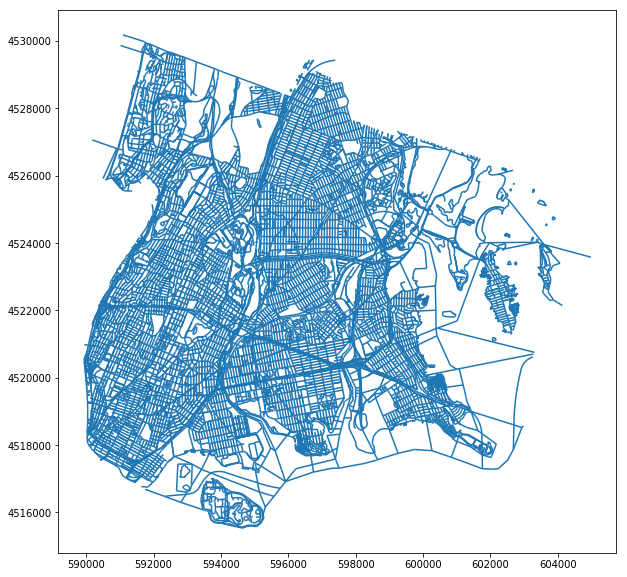

In [96]:
street_fig = plt.figure(figsize=(10,10))
ax = street_fig.add_subplot(111)
bronx_streets.plot(ax = ax)

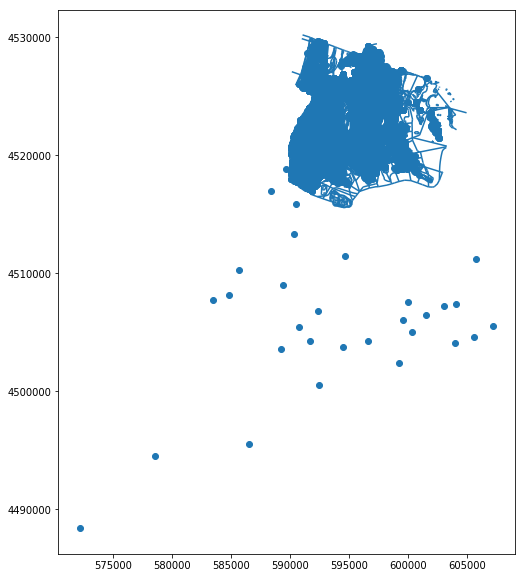

In [94]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
bronx_streets.plot(ax = ax)
bronx_crashes.plot(ax = ax)

(4515000, 4531000)

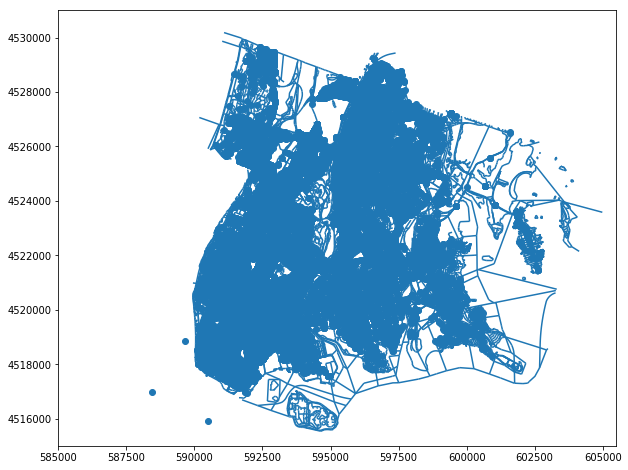

In [95]:
zoomed_fig = plt.figure(figsize=(10,10))
ax = zoomed_fig.add_subplot(111)
bronx_streets.plot(ax = ax)
bronx_crashes.plot(ax = ax)
plt.xlim(585000, 605500)
plt.ylim(4515000, 4531000)

In [7]:
def bronx_closest_street(point):
    distances = bronx_streets.geometry.apply(lambda street: street.distance(point))
    street_id = distances.argmin()
    if distances.min() < 250:
        return(streets.SegmentID[street_id])
    else:
        return -1

In [8]:
bronx_crashes['SegmentID'] = bronx_crashes.geometry.apply(bronx_closest_street)

/Users/rgalowich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rgalowich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
queens_streets = streets.loc[streets['LBoro'] == 4]
queens_crashes = crashes.loc[crashes['BOROUGH']=='QUEENS']

In [10]:
def queens_closest_street(point):
    distances = queens_streets.geometry.apply(lambda street: street.distance(point))
    street_id = distances.argmin()
    if distances.min() < 250:
        return(streets.SegmentID[street_id])
    else:
        return -1

In [12]:
queens_crashes['SegmentID'] = queens_crashes.geometry.apply(queens_closest_street)

/Users/rgalowich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rgalowich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
def join(crash_data,street_data,traffic_data):
    crash_subset = crash_data[['NUMBER_OF','NUMBER_O_2','SegmentID']].dropna().rename({"NUMBER_OF":"persons_injured","NUMBER_O_2":"pedestrians_injured"},axis=1)
    crash_groups = crash_subset.groupby('SegmentID').sum().drop(-1,axis=0)
    street_subset = street_data[['SegmentID','NodeIDFrom','NodeIDTo','LCB2010','RCB2010']]
    street_unique = street_subset.drop_duplicates()
    crash_join = street_unique.merge(crash_groups, how='left', on='SegmentID').fillna(0)
    traffic_volume = traffic_data.rename({'Segment ID':'SegmentID','segment_average_sum':'volume_count'},axis=1)
    traffic_subset = traffic_volume[['SegmentID','volume_count']]
    traffic_subset['SegmentID'] = traffic_subset['SegmentID'].astype(str)
    crash_join['SegmentID'] = crash_join['SegmentID'].astype(str).str.lstrip("0")
    street_edges = crash_join.merge(traffic_subset, how='left', on='SegmentID').fillna(0)
    n_matches = street_edges['volume_count'].astype(bool).sum(axis=0)
    return([street_edges,n_matches]) 

In [15]:
bronx_join = join(bronx_crashes,bronx_streets,traffic_volume)
queens_join = join(queens_crashes,queens_streets,traffic_volume)

/Users/rgalowich/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
print("Number of Bronx streets counted:", bronx_join[1], "\n")
print("Number of Queens streets counted:", queens_join[1])

Number of Bronx streets counted: 199 

Number of Queens streets counted: 254


In [18]:
bronx_edges = bronx_join[0]
queens_edges = queens_join[0]

In [21]:
bronx_edges.sort_values('volume_count',ascending=False).head()

,SegmentID,NodeIDFrom,NodeIDTo,LCB2010,RCB2010,persons_injured,pedestrians_injured,volume_count
14741,179545,0057113,0079107,1051,1003,0.0,0.0,68330.0
14002,73294,0044904,0044909,4001,1001,0.0,0.0,59087.0
835,73220,0044850,0044852,2000,4001,0.0,0.0,58463.0
14950,174566,0044854,0084498,1002,3001,0.0,0.0,56372.0
11544,178395,0098012,0053407,1036,1001,0.0,0.0,41085.0


In [22]:
queens_edges.sort_values('volume_count',ascending=False).head()

,SegmentID,NodeIDFrom,NodeIDTo,LCB2010,RCB2010,persons_injured,pedestrians_injured,volume_count
8907,65634,0040407,0040406,1015,1016,0.0,0.0,149883.0
27710,56804,0034962,0034963,1008,2001,0.0,0.0,68272.0
35456,119021,0070097,0036077,2010,1005,0.0,0.0,50437.0
38968,58623,0036138,0036225,4017,1014,0.0,0.0,41335.0
29719,54575,0033678,0033688,1010,1011,0.0,0.0,41152.0


In [33]:
traffic_volume = pd.read_csv("/Users/rgalowich/Documents/GitHub/cee345/node_slow_zone_indicators.csv")

In [27]:
bronx_nonzero_count = bronx_edges.loc[bronx_edges['volume_count']>0]
bronx_nonzero_count.shape

(199, 8)

In [29]:
queens_nonzero_count = queens_edges.loc[queens_edges['volume_count']>0]
queens_nonzero_count.shape

(254, 8)

In [31]:
bronx_edges.to_csv("all_bronx_edges.csv")
queens_edges.to_csv("all_queens_edges.csv")

In [32]:
bronx_nonzero_count.to_csv("bronx_traffic_edges.csv")
queens_nonzero_count.to_csv("queens_traffic_edges.csv")